# Single-cell ATAC-seq data analysis

### In scRNA-seq-like manner using scanpy



In [1]:
import anndata
from scipy.io import mmread
import scanpy as sc
import scipy
import numpy as np
import pandas as pd

In [2]:
np.random.seed(0)

In [3]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures/' # specifying output directory for figures
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.4 scipy==1.3.2 pandas==0.25.3 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [4]:
path = './'

### Reading in metadata

In [5]:
sample_info = pd.read_csv(path + 'qc_all.csv', index_col=0)
sample_info.set_index('cell',drop=False,inplace=True)
sample_info.head()
sample_min = sample_info[(sample_info['TREATMENT'] == 'CONTROL') & (sample_info['celltype'] == 'SM B-cells')]

In [6]:
sample_info.head(10)

,cell,uniq_frags,frip,frac_open,mapping_rate,sequencing_depth,dup_level,mt_content,library_size,plate,celltype,TREATMENT
cell,,,,,,,,,,,,
Immunodeficiency7827658,Immunodeficiency7827658,9935.0,0.779366,0.106160,93.41,43318,0.695859,0.107127,11679,NaN,SM B-cells,CONTROL
Immunodeficiency7827659,Immunodeficiency7827659,27316.0,0.798977,0.223372,95.27,283382,0.873763,0.118526,31003,NaN,USM B-cells,CONTROL
Immunodeficiency7827660,Immunodeficiency7827660,25011.0,0.736536,0.198050,94.81,211407,0.854074,0.048722,26326,NaN,SM B-cells,CONTROL
Immunodeficiency7827661,Immunodeficiency7827661,18966.0,0.803498,0.170654,95.39,145643,0.845663,0.035742,19705,NaN,USM B-cells,CONTROL
Immunodeficiency7827662,Immunodeficiency7827662,23561.0,0.824807,0.199707,95.07,220411,0.865661,0.079145,25604,NaN,SM B-cells,CONTROL
Immunodeficiency7827663,Immunodeficiency7827663,27588.0,0.806053,0.223436,94.63,228515,0.858282,0.022811,28262,NaN,USM B-cells,CONTROL
Immunodeficiency7827664,Immunodeficiency7827664,41252.0,0.729194,0.282557,94.74,428826,0.883617,0.012046,41765,NaN,SM B-cells,CONTROL
Immunodeficiency7827665,Immunodeficiency7827665,39770.0,0.740491,0.270089,94.62,402950,0.876889,0.073090,42922,NaN,USM B-cells,CONTROL
Immunodeficiency7827666,Immunodeficiency7827666,11406.0,0.713938,0.108428,93.42,40577,0.631721,0.091011,13787,NaN,SM B-cells,CONTROL


### Loading accessibility matrix

The preprocessing and QC of the matrix has been performed as per Xi Chen's pipeline, see https://github.com/dbrg77/plate_scATAC-seq

In [7]:
%%time

# load from mtx file

count = mmread(path + './raw_atac_matrix/tic198.mtx')
idxs = [i.strip() for i in open(path + './raw_atac_matrix/tic198.rownames')]
cols = [i.strip() for i in open(path + './raw_atac_matrix/tic198.colnames')]

sc_count = pd.DataFrame(data=count.toarray(),
                        index=idxs,
                        columns=cols)

to_drop = pd.read_csv(path + 'qc_bad_cells.csv',index_col='cell')

sc_count.drop(labels=to_drop.index, axis=1, inplace=True)

# binarise the data
bin_sc_count = sc_count.where(sc_count < 1, 1)
bin_sc_count.shape

CPU times: user 27.5 s, sys: 1.66 s, total: 29.2 s
Wall time: 28.5 s


(62161, 1242)

## Standard scanpy pipeline

In [8]:
bin_sc_count.head()

,Immunodeficiency7828495,Immunodeficiency7828442,Immunodeficiency7828878,Immunodeficiency7828496,Immunodeficiency7828895,Immunodeficiency7828403,Immunodeficiency7827811,Immunodeficiency7828563,Immunodeficiency7827769,Immunodeficiency7828462,...,Immunodeficiency7828123,Immunodeficiency7828475,Immunodeficiency7828422,Immunodeficiency7827736,Immunodeficiency7827979,Immunodeficiency7828374,Immunodeficiency7827692,Immunodeficiency7828091,Immunodeficiency7828103,Immunodeficiency7828505
aggregated_scATAC_peak_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
aggregated_scATAC_peak_2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
aggregated_scATAC_peak_3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aggregated_scATAC_peak_4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aggregated_scATAC_peak_5,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0


In [9]:
# creating anndata object
bin_adata = anndata.AnnData(X = bin_sc_count.T)
bin_adata.raw = bin_adata.copy()

In [10]:
# filter cells
# remove 5% of cells with low number of peaks
sc.pp.filter_cells(bin_adata, 
                   min_genes=round(np.percentile(bin_adata.X.sum(1), 5)))

bin_sc_count = bin_sc_count.loc[:,bin_sc_count.sum() > 7110]

# filter peaks
# at least two cells have the peak
sc.pp.filter_genes(bin_adata, min_cells=2)

bin_adata.X.shape

filtered out 63 cells that haveless than 7111.0 genes expressed


(1179, 62161)

In [11]:
# adding metadata to anndata object
bin_adata.obs['cell_id'] = bin_adata.obs.index
bin_adata.obs['celltype'] = bin_adata.obs['cell_id'].apply(lambda x: sample_info.loc[x, 'celltype'])
bin_adata.obs['condition'] = bin_adata.obs['cell_id'].apply(lambda x: sample_info.loc[x,'TREATMENT'])

In [12]:
bin_adata.X = scipy.sparse.csr_matrix(bin_adata.X)

In [13]:
bin_adata.obs.head()

,n_genes,cell_id,celltype,condition
Immunodeficiency7828495,15137,Immunodeficiency7828495,Naive B-cells,CVID
Immunodeficiency7828442,15972,Immunodeficiency7828442,Naive B-cells,CONTROL
Immunodeficiency7828878,11107,Immunodeficiency7828878,Naive B-cells,CONTROL
Immunodeficiency7828496,18458,Immunodeficiency7828496,USM B-cells,CVID
Immunodeficiency7828895,13793,Immunodeficiency7828895,Naive B-cells,CONTROL


In [14]:
%%time
# feature (gene) scaling
sc.pp.scale(bin_adata, max_value=10)

CPU times: user 308 ms, sys: 312 ms, total: 620 ms
Wall time: 622 ms


In [15]:
%%time
# PCA
sc.tl.pca(bin_adata, svd_solver='arpack')

computing PCA with n_comps = 50
    finished (0:00:08)
CPU times: user 51.8 s, sys: 1min 6s, total: 1min 58s
Wall time: 8.15 s


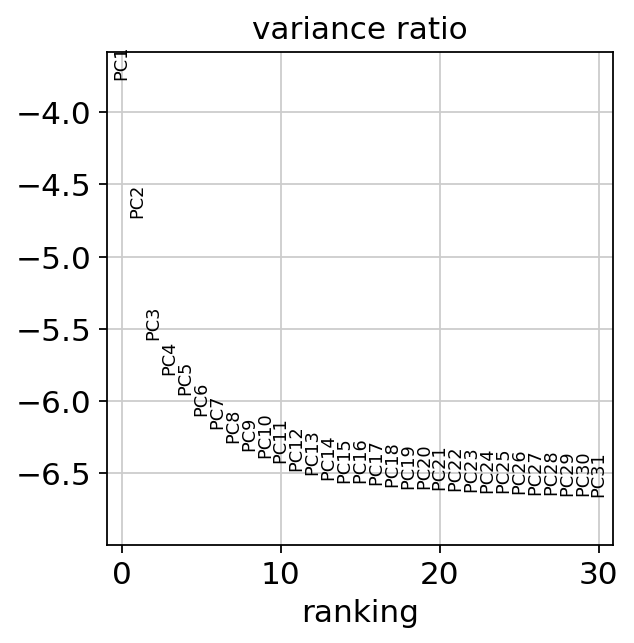

In [16]:
sc.pl.pca_variance_ratio(bin_adata, log=True)

In [17]:
%%time
# building neighborhood graph
sc.pp.neighbors(bin_adata, n_neighbors=10, n_pcs=20)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:01)
CPU times: user 2.52 s, sys: 2.03 s, total: 4.55 s
Wall time: 1.78 s


In [18]:
%%time
sc.tl.umap(bin_adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
CPU times: user 3.84 s, sys: 1.68 s, total: 5.51 s
Wall time: 3.39 s


In [19]:
bin_adata

AnnData object with n_obs × n_vars = 1179 × 62161 
    obs: 'n_genes', 'cell_id', 'celltype', 'condition'
    var: 'n_cells'
    uns: 'pca', 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

... storing 'celltype' as categorical
... storing 'condition' as categorical


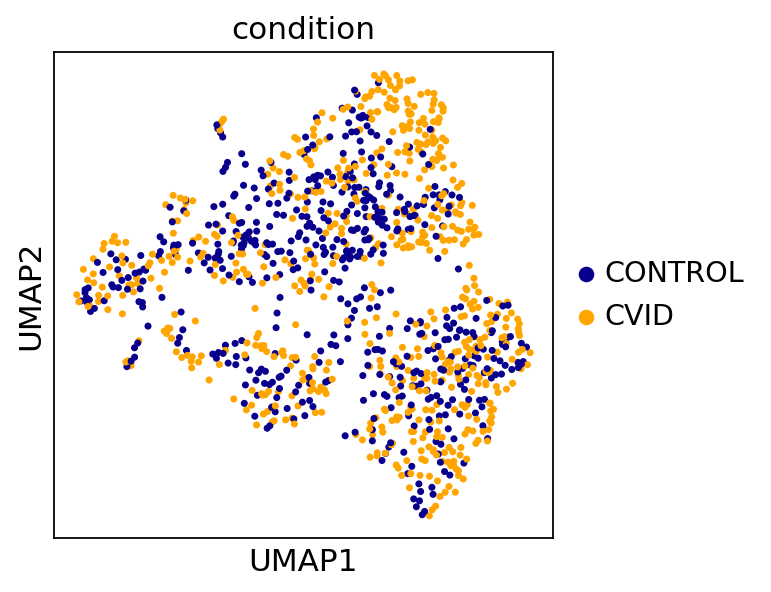

In [20]:
sc.pl.umap(bin_adata, color='condition', s=40, palette = ['#08008c','#ffa500'],
          save='_atac_condition.pdf')

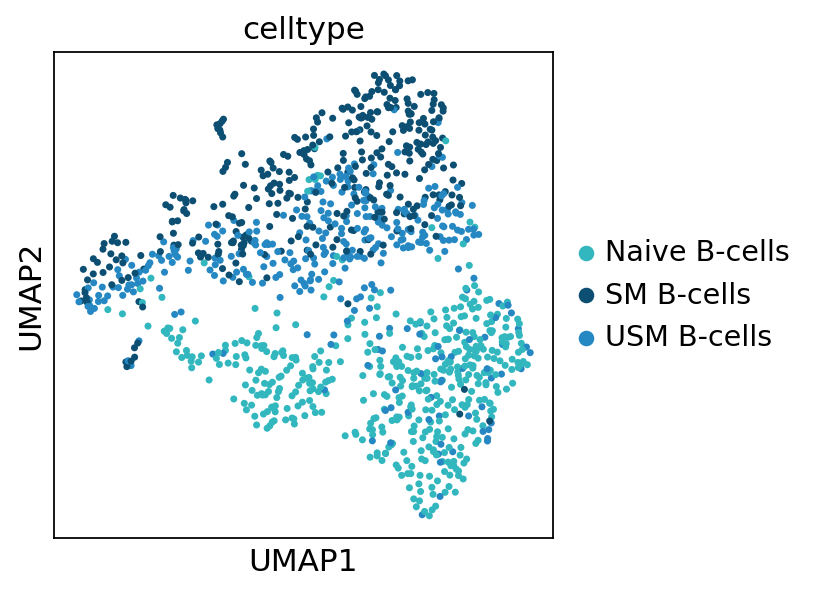

In [21]:
sc.pl.umap(bin_adata, color='celltype', s=40, palette = ['#32b7bf',
                                                         '#0c4f73', '#2688c2'],
          save='_atac_celltype.pdf')

In [22]:
# saving this object
bin_adata.write('bin_adata_atac_object_final.h5ad')

In [23]:
bin_adata = sc.read('bin_adata_atac_object_final.h5ad')